In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
from glob import glob

### theory data

In [2]:
THEORY_POWERS = [10, 50, 100]
THEORY_DELAYS = [10, 30, 50, 70, 90, 110]
THEORY_INTEGRATING_DELAYS = [25, 40, 75]

THEORY_XLIM = [0.5, 3.0]

def load_theory_result(power, delays=THEORY_DELAYS):

    dirmap = {
        10: "fig4a",
        50: "fig4b",
        100: "fig4c",
    }

    q_values = None
    intensities = []

    for delay in delays:
        file_path = f"{dirmap[power]}/rdp47_{power:03d}_{delay:03d}fs.txt"
        data = np.loadtxt(file_path)

        if q_values is not None:
            assert np.all(q_values == data[:,0] / 1e10)
        else:
            q_values = data[:,0] / 1e10

        intensities.append(data[:,1])

    data_stack = np.stack([q_values] + intensities)
    assert data_stack.shape[0] == len(delays) + 1

    return data_stack.T


def load_theory_integrating(power, delays=THEORY_INTEGRATING_DELAYS, box_size="30"):

    q_values = None
    intensities = []

    for delay in delays:
        file_path = f"fig5/rdp{box_size}_cal_{power:03d}_{delay:02d}fs.txt"
        data = np.loadtxt(file_path)

        if q_values is not None:
            assert np.all(q_values == data[:,0] / 1e10)
        else:
            q_values = data[:,0] / 1e10

        intensities.append(data[:,1])

    data_stack = np.stack([q_values] + intensities)
    assert data_stack.shape[0] == len(delays) + 1

    return data_stack.T


def normalize(radial_profile, rng=(50, 340)):
    div = radial_profile[...,rng[0]:rng[1]].sum(-1)[...,None]
    return radial_profile / ( div + 1e-16)

### integrated pulses (original fig 5)

In [3]:
integrating_10power = load_theory_integrating(10, box_size="47")
integrating_100power = load_theory_integrating(100, box_size="47")

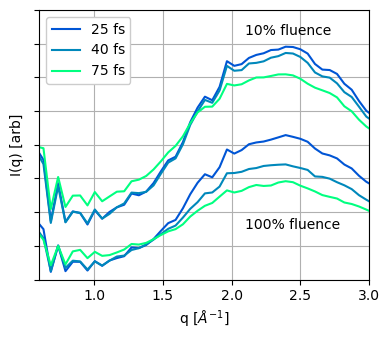

In [4]:
plt.figure(figsize=(4,3.5))

ax = plt.subplot(111)

for i,b in enumerate(THEORY_INTEGRATING_DELAYS):
    plt.plot(integrating_10power[:,0], integrating_10power[:,i+1] + 2e4, color=plt.cm.winter(b/np.array(THEORY_INTEGRATING_DELAYS).max()))
    plt.plot(integrating_100power[:,0], integrating_100power[:,i+1], color=plt.cm.winter(b/np.array(THEORY_INTEGRATING_DELAYS).max()), label="_nolegend_")

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.grid()
ax.set_xlim([0.6,3.0])
ax.set_yticklabels([])

plt.legend(
    ['%d fs' % b for b in THEORY_INTEGRATING_DELAYS], 
    prop={'size': 10},
    ncol=1,
    framealpha=1.0,
    loc=2
)

ax.text(2.1, 1.65e5, "10% fluence")
ax.text(2.1, 5.0e4, "100% fluence")
ax.set_ylim([2e4, 1.8e5])

plt.tight_layout()
plt.savefig("./integrated_pulse_simulation.png")
plt.show()

### experimental vs simulation (original figs 1 + 4)

In [5]:
experimental_data = np.loadtxt("../csvs/water_Iq_v_time.csv", delimiter=',')
print(experimental_data.shape)
EXPERIMENTAL_DELAYS = np.array([10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,110.0])

(500, 12)


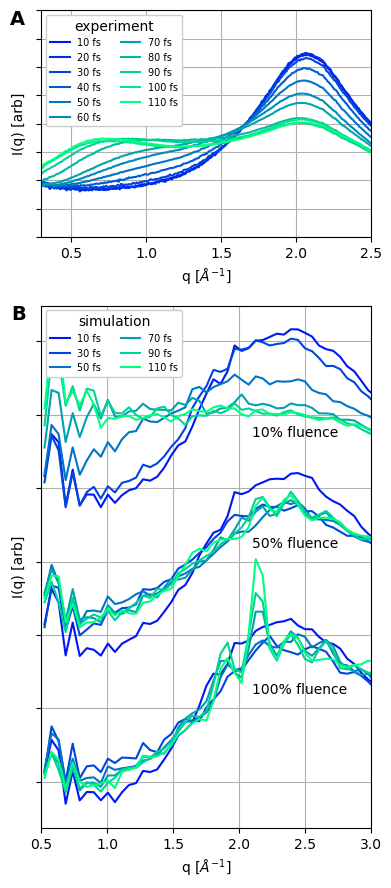

In [6]:
# RP vs Delay Time

# --- peak positions to monitor later (in array idx)
new_peak_pos = 90
wat_peak_pos = 280
XLIM = [0.3, 2.5]
GRID = True
NORMALIZE = True

# --- plotting
fig = plt.figure(figsize=(4,3*3))
gs = gridspec.GridSpec(3, 1)

ax = fig.add_subplot(gs[0])

for i,b in enumerate(EXPERIMENTAL_DELAYS):
    ax.plot(experimental_data[:,0], experimental_data[:,i+1], color=plt.cm.winter(b/EXPERIMENTAL_DELAYS.max()))

ax.set_xlabel('q [$\AA^{-1}]$')
ax.set_ylabel('I(q) [arb]')
ax.set_xlim(XLIM)
ax.set_ylim([0.0, 0.008])
ax.set_yticklabels([])
if GRID: ax.grid()

plt.legend(
    ['%d fs' % b for b in EXPERIMENTAL_DELAYS], 
    prop={'size': 7},
    ncol=2,
    framealpha=1.0,
    title="experiment"
)

ax.text(0.09, 0.0075, "A", fontdict={'weight' : 'bold', 'size' : 14})

# ----------

ax = fig.add_subplot(gs[1:])

for ax_i, theory_power in enumerate(THEORY_POWERS):

    theoretical_data = load_theory_result(theory_power)

    for i,b in enumerate(THEORY_DELAYS):

        offset = 0.02

        if NORMALIZE:
            y = normalize(theoretical_data[:,i+1], rng=[0, -1])
        else:
            y = theoretical_data[:,i+1]

        ax.plot(
            theoretical_data[:,0], y - ax_i * offset,
            color=plt.cm.winter(b/np.array(THEORY_DELAYS).max())
        )

ax.text(0.27, 0.033, "B", fontdict={'weight' : 'bold', 'size' : 14})

ax.text(2.1,  0.017, f"10% fluence")
ax.text(2.1,  0.002, f"50% fluence")
ax.text(2.1, -0.018, f"100% fluence")

ax.set_xlabel('q [$\AA^{-1}]$')
ax.set_ylabel('I(q) [arb]')
ax.set_xlim(THEORY_XLIM)
#ax.set_xlim(XLIM)
ax.set_yticklabels([])
if GRID: ax.grid()

plt.legend(
    ['%d fs' % b for b in THEORY_DELAYS], 
    prop={'size': 7},
    ncol=2,
    framealpha=1.0,
    loc=2,
    title=f"simulation"
)

plt.tight_layout()
plt.savefig("./experiment-simulation-combined_two-pulse_normalized_same-qaxis.png")
plt.show()

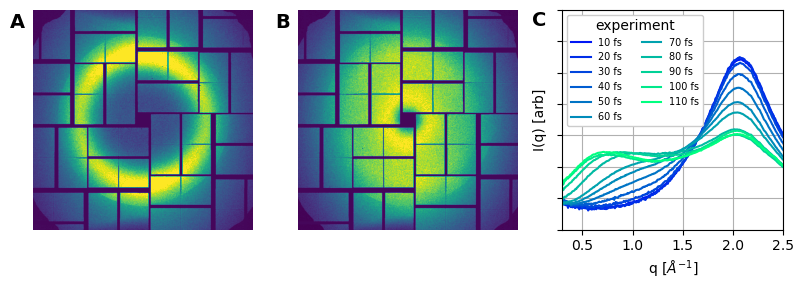

In [7]:
# just the experiment alone

fig = plt.figure(figsize=(8,3))

probe_only = np.load("run129_10shot_average.npy")
pump_probe = np.load("run127_10shot_average.npy")
image_slice = np.s_[150:-150,150:-150]

ax = plt.subplot(131)
probe_only[probe_only > 100] = 0
plt.imshow(probe_only[image_slice], vmin=-1, vmax=60)
ax.axis("off")
ax.text(-150, 115, "A", fontdict={'weight' : 'bold', 'size' : 14})

ax = plt.subplot(132)
pump_probe[pump_probe > 100] = 0
plt.imshow(pump_probe[image_slice], vmin=-1, vmax=60)
ax.axis("off")
ax.text(-150, 115, "B", fontdict={'weight' : 'bold', 'size' : 14})

ax = plt.subplot(133)
for i,b in enumerate(EXPERIMENTAL_DELAYS):
    ax.plot(experimental_data[:,0], experimental_data[:,i+1], color=plt.cm.winter(b/EXPERIMENTAL_DELAYS.max()))

ax.set_xlabel('q [$\AA^{-1}]$')
ax.set_ylabel('I(q) [arb]')
ax.set_xlim(XLIM)
ax.set_ylim([0.001, 0.008])
ax.set_yticklabels([])
if GRID: ax.grid()

plt.legend(
    ['%d fs' % b for b in EXPERIMENTAL_DELAYS], 
    prop={'size': 7},
    ncol=2,
    framealpha=1.0,
    title="experiment"
)

ax.text(0, 0.0075, "C", fontdict={'weight' : 'bold', 'size' : 14})

plt.tight_layout()
plt.savefig("./experiment-only_two-pulse_normalized.png")
plt.show()

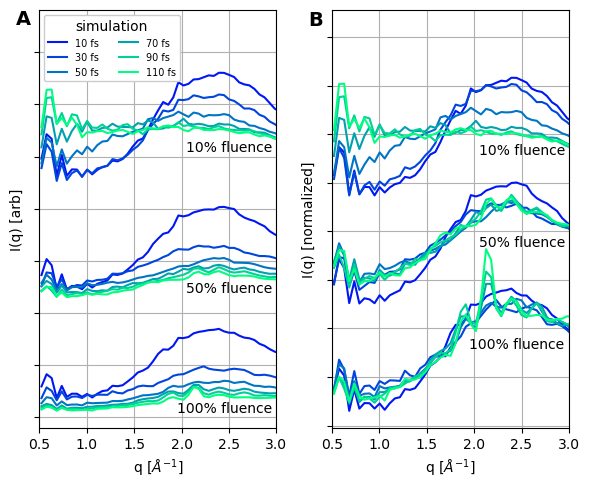

In [8]:
# just the simulation alone, normalized and unnormalized

fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(1, 2)

for ax_i in range(2):

    ax = fig.add_subplot(gs[ax_i])

    for power_index, theory_power in enumerate(THEORY_POWERS):

        theoretical_data = load_theory_result(theory_power)

        for i,b in enumerate(THEORY_DELAYS):

            if ax_i == 1:
                y = normalize(theoretical_data[:,i+1], rng=[0, -1])
                offset = 0.022
            else:
                y = theoretical_data[:,i+1]
                offset = 100000.0

            ax.plot(
                theoretical_data[:,0], y - power_index * offset,
                color=plt.cm.winter(b/np.array(THEORY_DELAYS).max())
            )

    if ax_i == 1:
        ax.set_ylabel('I(q) [normalized]')
        ax.text(0.25, 0.0425, "B", fontdict={'weight' : 'bold', 'size' : 14})
        ax.text(2.05,  0.016, f"10% fluence")
        ax.text(2.05, -0.003, f"50% fluence")
        ax.text(1.95, -0.024, f"100% fluence")
    
    else:
        ax.set_ylabel('I(q) [arb]')
        ax.text(0.25,  177000, "A", fontdict={'weight' : 'bold', 'size' : 14})
        ax.text(2.05,   55000, f"10% fluence")
        ax.text(2.05,  -80000, f"50% fluence")
        ax.text(1.95, -195000, f"100% fluence")

    ax.set_xlabel('q [$\AA^{-1}]$')
    ax.set_xlim(THEORY_XLIM)
    ax.set_yticklabels([])
    if GRID: ax.grid()

    if ax_i == 0:
        plt.legend(
            ['%d fs' % b for b in THEORY_DELAYS], 
            prop={'size': 7},
            ncol=2,
            framealpha=1.0,
            loc=2,
            title=f"simulation"
        )

    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin, ymax * 1.3])

plt.tight_layout()
plt.savefig("./simulation-only.png")
plt.show()

### oxygen ionization states (original figure 2)

- ion*: average ionization degree of oxygen
- first column: time[fs], 0fs = center of the pump pulse
- second column: average ionization degree [-]

- csp*: charge state population
- first column: time[fs], 0fs = center of the pump pulse
- columns 2 and higher give relative populations (0 to 1) of ionization stages of oxygen (neutral,1+,..)

note: figures do not show all columns that are included in data files.

In [9]:
csp_010 = np.genfromtxt("./fig2/csp47_010_single.txt")
csp_100 = np.genfromtxt("./fig2/csp47_100_single.txt")

ion_010 = np.genfromtxt("./fig2/ion47_010_single.txt")
ion_100 = np.genfromtxt("./fig2/ion47_100_single.txt")

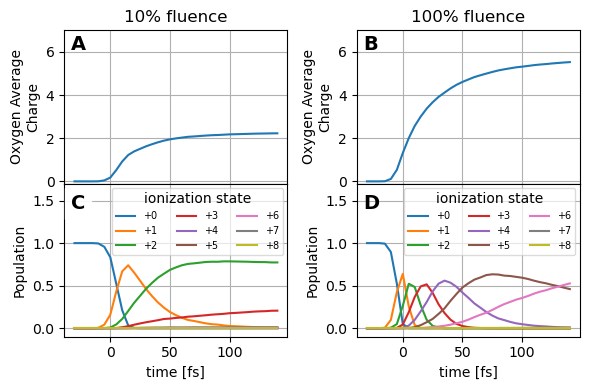

In [10]:
fix, axes = plt.subplots(2, 2, sharex=True, figsize=(6,4))

axes[0,0].plot(ion_010[:,0], ion_010[:,1])
axes[0,1].plot(ion_100[:,0], ion_100[:,1])

axes[0,0].set_title("10% fluence")
axes[0,1].set_title("100% fluence")

for i in range(2):
    axes[0,i].set_ylim([-0.1, 7.0])
    axes[0,i].set_ylabel("Oxygen Average\nCharge")
    axes[0,i].grid()

# --------

axes[1,0].plot(csp_010[:,0], csp_010[:,1:])
axes[1,1].plot(csp_100[:,0], csp_100[:,1:])

for i in range(2):
    axes[1,i].set_ylim([-0.1, 1.7])
    axes[1,i].set_ylabel("Population")
    axes[1,i].grid()

    axes[1,i].legend(
        [f"+{i}" for i in range(9)],
        loc=1, 
        ncol=3,
        prop={'size': 7},
        framealpha=0.7,
        title="ionization state",
    )

# --------

for i in range(2):
    axes[1,i].set_xlabel('time [fs]')

# --------

axes[0,0].text(-33, 6.1, "A", fontdict={'weight' : 'bold', 'size' : 14})
axes[0,1].text(-33, 6.1, "B", fontdict={'weight' : 'bold', 'size' : 14})

t = axes[1,0].text(-33, 1.4, "C", fontdict={'weight' : 'bold', 'size' : 14})
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white'))
axes[1,1].text(-33, 1.4, "D", fontdict={'weight' : 'bold', 'size' : 14})
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white'))

# --------

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("ionization_states.png")
plt.show()

### form factor vs structure factor contribution (original figure 3)

In [11]:
def load_factor_block(fluence):

    data = [
        np.genfromtxt("./fig3/rdp47_undam_water.txt")[:,0] / 1e10,
        np.genfromtxt("./fig3/rdp47_undam_water.txt")[:,1],
        np.genfromtxt(f"./fig3/rdp47_{fluence}_disponly.txt")[:,1],
        np.genfromtxt(f"./fig3/rdp47_{fluence}_formfonly.txt")[:,1],
        np.genfromtxt(f"./fig3/rdp47_{fluence}_fulldam.txt")[:,1],
    ]

    return np.vstack(data).T

factor_block_010 = load_factor_block("010")
factor_block_100 = load_factor_block("100")

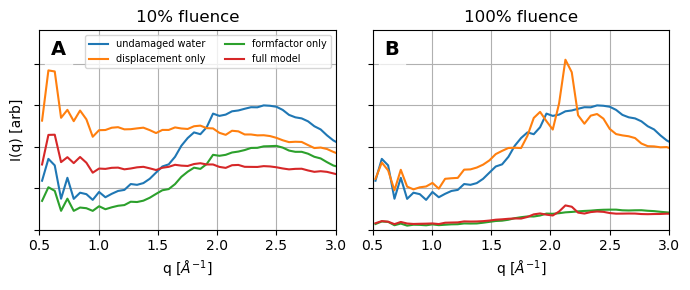

In [12]:
plt.figure(figsize=(7,3))

for ib, block in enumerate([factor_block_010, factor_block_100]):

    ax = plt.subplot(1, 2, ib+1)

    for i in range(4):
        plt.plot(block[:,0], block[:,i+1])

    ax.set_yticklabels([])
    ax.set_xlabel('q [$\AA^{-1}]$')
    ax.set_xlim(THEORY_XLIM)
    ax.set_ylim([0,2.4e5])
    ax.grid()

    if ib == 0:
        plot_label = "A"

        ax.set_title("10% fluence")
        ax.set_ylabel('I(q) [arb]')
        plt.legend(
            [
                "undamaged water",
                "displacement only",
                "formfactor only",
                "full model"
            ],
            loc=1,
            ncol=2,
            prop={'size': 7},
        )
    elif ib == 1:
        plot_label = "B"
        ax.set_title("100% fluence")

    text = ax.text(0.6, 2.1e5, plot_label, fontdict={'weight' : 'bold', 'size' : 14})
    text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.tight_layout()
plt.savefig("./formfactor_vs_structurefactor.png")
plt.show()

## Original figure S1 and S2

In [13]:
low_fluence_si_data = np.vstack([
    np.genfromtxt(f"./figS1/rdp30_010_140fs_renorm.txt")[:,0] / 1e10,
    np.genfromtxt(f"./figS1/rdp30_010_140fs_renorm.txt")[:,1],
    np.genfromtxt(f"./figS1/rdp47_010_140fs.txt")[:,1],
    np.genfromtxt(f"./figS1/rdp60_010_140fs_renorm.txt")[:,1],
]).T

high_fluence_si_data = np.vstack([
    np.genfromtxt(f"./figS2/rdp30_100_140fs_renorm.txt")[:,0] / 1e10,
    np.genfromtxt(f"./figS2/rdp30_100_140fs_renorm.txt")[:,1],
    np.genfromtxt(f"./figS2/rdp47_100_140fs.txt")[:,1],
]).T


print(low_fluence_si_data.shape)
print(high_fluence_si_data.shape)

(50, 4)
(50, 3)


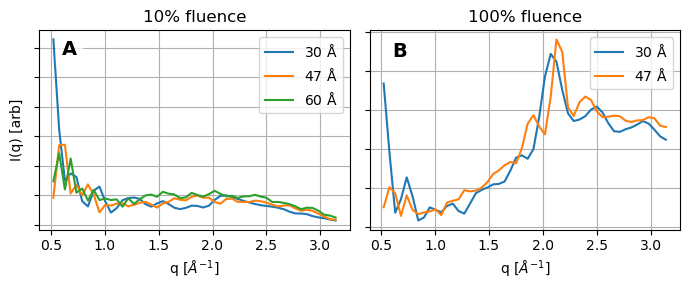

In [14]:
plt.figure(figsize=(7,3))

for ib, block in enumerate([low_fluence_si_data, high_fluence_si_data]):

    ax = plt.subplot(1, 2, ib+1)

    for i in range(block.shape[1]-1):
        plt.plot(block[:,0], block[:,i+1])

    ax.set_yticklabels([])
    ax.set_xlabel('q [$\AA^{-1}]$')
    #ax.set_xlim(THEORY_XLIM)
    #ax.set_ylim([0,2.4e5])
    ax.grid()

    plt.legend(
        [
            "30 $\mathrm{\AA}$",
            "47 $\mathrm{\AA}$",
            "60 $\mathrm{\AA}$",
        ],
        loc=1,
        ncol=1,
    )

    if ib == 0:
        plot_label = "A"
        ax.set_title("10% fluence")
        ax.set_ylabel('I(q) [arb]')
        text = ax.text(0.6, 1.75e5, plot_label, fontdict={'weight' : 'bold', 'size' : 14})

    elif ib == 1:
        plot_label = "B"
        ax.set_title("100% fluence")
        text = ax.text(0.6, 2.68e4, plot_label, fontdict={'weight' : 'bold', 'size' : 14})

    text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.tight_layout()
plt.savefig("./supplementary_figure_effect_of_box.png")
plt.show()

### Plot of power dependence

In [108]:
# --- peak positions to monitor later (in array idx)
new_peak_pos = 98
wat_peak_pos = 280

iq_vs_power_data = {}

for power_csv in glob("../csvs/water_Iq_v_power_*.csv"):
    print(f"loading {power_csv}")
    data = np.loadtxt(power_csv, delimiter=',')
    delay = float(power_csv.split("_")[-1].split(".")[0][:-2])
    iq_vs_power_data[delay] = data

loading ../csvs/water_Iq_v_power_50fs.csv
loading ../csvs/water_Iq_v_power_90fs.csv
loading ../csvs/water_Iq_v_power_70fs.csv
loading ../csvs/water_Iq_v_power_110fs.csv
loading ../csvs/water_Iq_v_power_30fs.csv
loading ../csvs/water_Iq_v_power_10fs.csv
loading ../csvs/water_Iq_v_power_40fs.csv
loading ../csvs/water_Iq_v_power_80fs.csv
loading ../csvs/water_Iq_v_power_60fs.csv
loading ../csvs/water_Iq_v_power_20fs.csv
loading ../csvs/water_Iq_v_power_100fs.csv


In [109]:
time_delays = sorted(list(iq_vs_power_data.keys()))

time_power_data_stack = np.zeros((len(time_delays), iq_vs_power_data[time_delays[0]].shape[0]-1, iq_vs_power_data[time_delays[0]].shape[1]-2))

for it, time_delay in enumerate(time_delays):
    time_power_data_stack[it,:,:] = iq_vs_power_data[time_delay][1:,2:]

# shape: (time, q, power)
print(time_power_data_stack.shape)

(11, 499, 9)


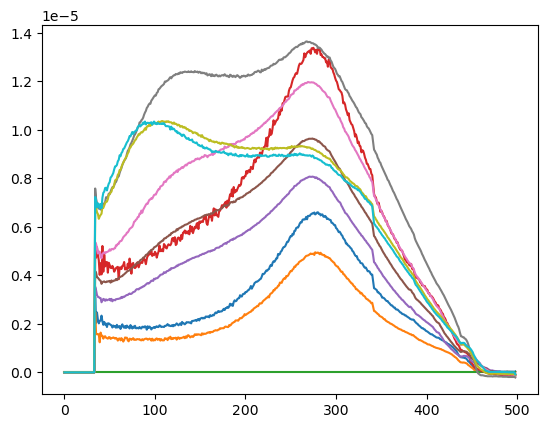

In [110]:
plt.figure()
for i in range(10):
    plt.plot(time_power_data_stack[i,:,5])
#plt.vlines([wat_peak_pos, new_peak_pos], 0, 0.008)
plt.show()

In [111]:
#normalize = lambda x : x
def normalize(radial_profile, rng=(60, 320)):
    auc = radial_profile[:,rng[0]:rng[1],:].sum(1)[:,None,:]
    return radial_profile / (auc + 1e-16)
    
auc_to_mJ = 1.60324933931e-07

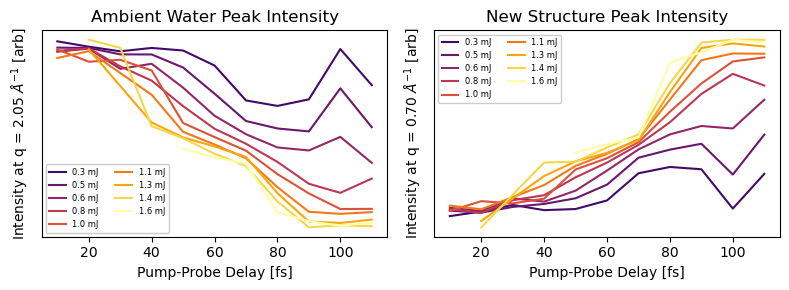

In [112]:
pump_powers = np.array([2000000.0,3000000.0,4000000.0,5000000.0,6000000.0,7000000.0,8000000.0,9000000.0,10000000])
normalized_time_power_data_stack = normalize(time_power_data_stack)

time_delays = np.array(time_delays)


plt.figure(figsize=(8,3))

ax = plt.subplot(121)
plt.title('Ambient Water Peak Intensity')
for power_index, power in enumerate(pump_powers):

    y = normalized_time_power_data_stack[:,wat_peak_pos,power_index]
    plt.plot(
        time_delays[y>0],
        y[y>0],
        color=cm.inferno(power/pump_powers.max())
    )
    
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.ylabel('Intensity at q = 2.05 $\AA^{-1}$ [arb]')
plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
          prop={'size': 6}, ncol=2, framealpha=1.0)
ax.get_yaxis().set_ticks([])
    
ax = plt.subplot(122)
plt.title('New Structure Peak Intensity')
for power_index, power in enumerate(pump_powers):
    
    y = normalized_time_power_data_stack[:,new_peak_pos,power_index]
    plt.plot(
        time_delays[y>0],
        y[y>0],
        color=cm.inferno(power/pump_powers.max())
    )
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
          prop={'size': 6}, ncol=2, framealpha=1.0)
plt.ylabel('Intensity at q = 0.70 $\AA^{-1}$ [arb]')
ax.get_yaxis().set_ticks([])
    
plt.tight_layout()
#plt.savefig('figures/peak_ints_vs_delay-power_%s.pdf' % ds_name)
plt.show()

## combine time and fluence dep.

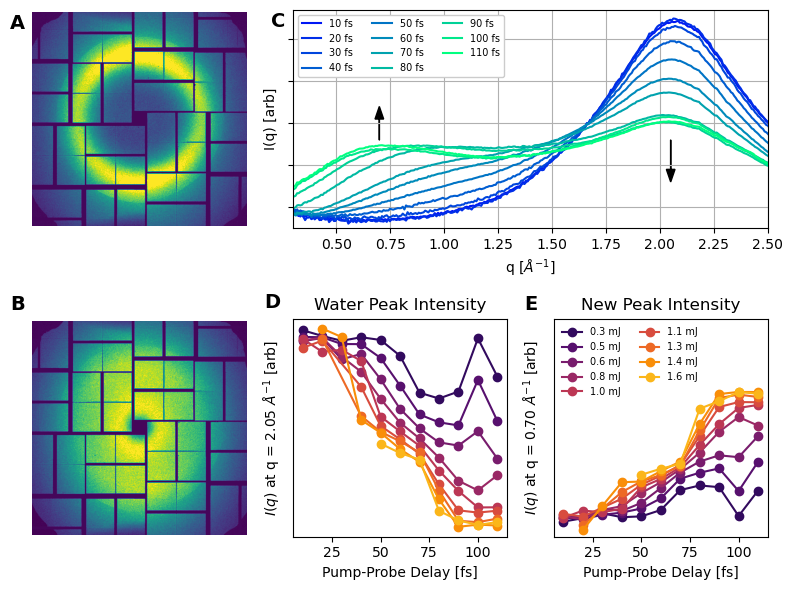

In [134]:
# just the experiment alone

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(2, 3)

probe_only = np.load("run129_10shot_average.npy")
pump_probe = np.load("run127_10shot_average.npy")
image_slice = np.s_[150:-150,150:-150]

ax = fig.add_subplot(gs[0,0])
probe_only[probe_only > 100] = 0
plt.imshow(probe_only[image_slice], vmin=-1, vmax=60)
ax.axis("off")
ax.text(-150, 115, "A", fontdict={'weight' : 'bold', 'size' : 14})

ax = fig.add_subplot(gs[1,0])
pump_probe[pump_probe > 100] = 0
plt.imshow(pump_probe[image_slice], vmin=-1, vmax=60)
ax.axis("off")
ax.text(-150, -70, "B", fontdict={'weight' : 'bold', 'size' : 14})

# -------------------------------

ax = fig.add_subplot(gs[0,1:])
for i,b in enumerate(EXPERIMENTAL_DELAYS):
    ax.plot(experimental_data[:,0], experimental_data[:,i+1], color=plt.cm.winter(b/EXPERIMENTAL_DELAYS.max()))

ax.set_xlabel('q [$\AA^{-1}]$')
ax.set_ylabel('I(q) [arb]')
ax.set_xlim(XLIM)
ax.set_ylim([0.0015, 0.0067])
ax.set_yticklabels([])
if GRID: ax.grid()

ax.arrow(
    0.7, 0.0036, 0, 0.0005,
    color='k',
    head_width=0.04, 
    head_length=0.0003
)
ax.arrow(
    2.05, 0.0036, 0, -0.0007,
    color='k',
    head_width=0.04, 
    head_length=0.0003
)

plt.legend(
    ['%d fs' % b for b in EXPERIMENTAL_DELAYS], 
    prop={'size': 7},
    ncol=3,
    framealpha=1.0,
)

ax.text(0.2, 0.0063, "C", fontdict={'weight' : 'bold', 'size' : 14})

# -------------------------------

pump_powers = np.array([2000000.0,3000000.0,4000000.0,5000000.0,6000000.0,7000000.0,8000000.0,9000000.0,10000000])
normalized_time_power_data_stack = normalize(time_power_data_stack)

inferno_offset = 1.2 # changes color scale

time_delays = np.array(time_delays)

ax = fig.add_subplot(gs[1,1])
plt.title('Water Peak Intensity')
for power_index, power in enumerate(pump_powers):

    y = normalized_time_power_data_stack[:,wat_peak_pos,power_index]
    plt.plot(
        time_delays[y>0],
        y[y>0],
        "o-",
        color=cm.inferno(power/(pump_powers.max() * inferno_offset))
    )
    
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.ylabel('$I(q)$ at q = 2.05 $\AA^{-1}$ [arb]')
# plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
#           prop={'size': 7}, ncol=2, framealpha=1.0)
ax.get_yaxis().set_ticks([])
water_peak_ylim = ax.get_ylim()

ax.text(-10, 0.0078, "D", fontdict={'weight' : 'bold', 'size' : 14})

# ----
    
ax = fig.add_subplot(gs[1,2])
plt.title('New Peak Intensity')
for power_index, power in enumerate(pump_powers):
    
    y = normalized_time_power_data_stack[:,new_peak_pos,power_index]
    plt.plot(
        time_delays[y>0],
        y[y>0],
        "o-",
        color=cm.inferno(power/(pump_powers.max() * inferno_offset))
    )
    
plt.xlabel('Pump-Probe Delay [fs]')
plt.legend(['%.1f mJ' % (float(p) * auc_to_mJ,) for p in pump_powers],
          prop={'size': 7}, ncol=2, framealpha=1.0, frameon=False)
plt.ylabel('$I(q)$ at q = 0.70 $\AA^{-1}$ [arb]')
ax.get_yaxis().set_ticks([])
#ax.set_ylim(water_peak_ylim)

old_ylim = ax.get_ylim()
ax.set_ylim([old_ylim[0], old_ylim[1]*1.3])

ax.text(-10, 0.00625, "E", fontdict={'weight' : 'bold', 'size' : 14})
    

plt.tight_layout()
plt.savefig("./experiment_cspad_time_and_power.png")
plt.show()